# Rodeo Algorithm for the Ising Model

This notebook will implement the [Rodeo Algorithm](https://arxiv.org/abs/2009.04092) for the [Ising model](https://en.wikipedia.org/wiki/Ising_model) and run it on hardware

In [1]:
from qiskit import *
from qiskit.tools.visualization import circuit_drawer
import matplotlib.pyplot as plt
import numpy as np

First, we must define a function for a single cycle of the Rodeo Algorithm. This involves implementing the time evolution of the Ising model Hamiltonian Operator.

The Hamiltonian for the Ising model is $\hat{H}=-J \sum_{<i,j>} \sigma_{i}^Z \sigma_{j}^Z - \sum_{j} h \sigma_{j}^Z$. In this example, we will assume there is no external field, i.e., $h=0$. So, effectively, $\hat{H}=-J \sum_{<i,j>} \sigma_{i}^Z \sigma_{j}^Z$

We want the hamiltonian evolution to be controlled by the ancilla qubit, so we will use controlled reversal gates as described in [this paper](https://arxiv.org/abs/2208.13557). Since our hamiltonian is made up of Pauli Z's, we will use controlled Pauli Y gates to control the time evolution.

The function call below will produce a single cycle of the Rodeo Algorithm for a 3 qubit Hamiltonian with the specified parameters.

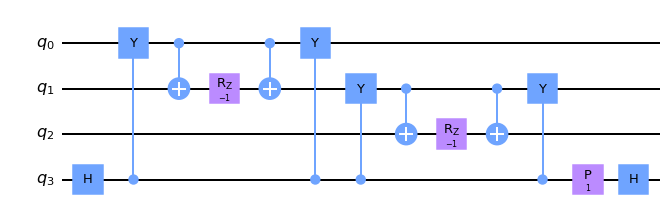

In [2]:
def cycle(j:"float", deltat:"float", E:"float", nqubits:"int")-> QuantumCircuit:
    circ = QuantumCircuit(nqubits+1)
    circ.h(nqubits)
    # This loop implements the Ising time evolution for each pair of object qubits.
    # It also includes CY gates controlled on the ancilla qubit to make the time evolution controlled
    for obj_qubit in range(0, nqubits-1):
        circ.cy(nqubits, obj_qubit)
        circ.cx(obj_qubit,obj_qubit+1)
        circ.rz(-1*j*deltat, obj_qubit+1)
        circ.cx(obj_qubit,obj_qubit+1)
        circ.cy(nqubits, obj_qubit)
    circ.p(E*deltat, nqubits)
    circ.h(nqubits)
    
    return circ

circuit = cycle(j=1, deltat=1, E=1, nqubits=3)
circuit.draw(output = 'mpl')

Next, we must put multiple cycles of the Rodeo Algorithm together in one Rodeo Circuit. Note that we initially add Hadamard gates to all the object qubits in order to get the whole energy spectrum in our final run. We also use [mid-circuit measurements](https://quantum-computing.ibm.com/lab/docs/iql/manage/systems/midcircuit-measurement/) to measure the ancilla qubit after each cycle. We must also sample `deltat` for each cycle from a gaussian distribution of mean `t` and standard deviation `sigma`.

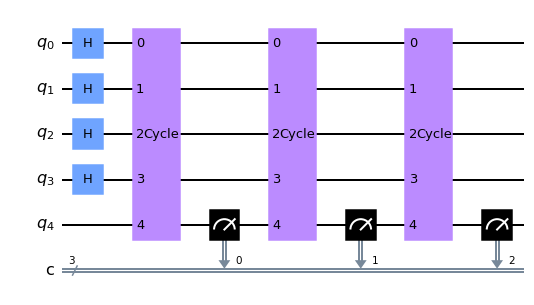

In [3]:
def rodeo_circuit(j:"float", t:"float", sigma:"float", E:"float", nqubits:"int", n_cycles:"int")-> QuantumCircuit:
    circuit = QuantumCircuit(nqubits+1, n_cycles)
    for obj_qubit in range(nqubits):
        circuit.h(obj_qubit)
    for c in range(n_cycles):
        deltat = np.random.normal(t, sigma)
        cycle_gate = cycle(j, deltat, E, nqubits).to_gate(label=r'Cycle')
        circuit.append(cycle_gate, range(0,nqubits+1))
        circuit.measure(nqubits, c)
    return circuit

circ = rodeo_circuit(j=1, t=0, sigma=2, E=2, nqubits=4, n_cycles=3)
circ.draw(output = 'mpl')

# Uncomment the line below to see the individual gates for each cycle
# circ.decompose().draw(output = 'mpl')

Now, we can create and run a series of Rodeo Circuits for a number of energies to determine the energy spectrum. We will use Qiskit Runtime to run this on an IBM Quantum Computer.

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Sampler

service = QiskitRuntimeService(channel = 'ibm_quantum')
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=5)
session = Session(service = service, backend = backend)
options = Options()
options.resilience_level = 1 #This ensures that some error mitigation is being used
sampler = Sampler(session = session, options = options)


"""Fucntion that plots the energy spectrum for the Ising Model for the given parameters using the Rodeo Algorithm

Args:
    E_min: Minimum energy value in the energy spectrum
    E_max: Maximum enery value in the energy spectrum
    num_samples: Number of energies in the energy spectrum
    t: Mean of time distribution to be sampled from
    sigma: Root-mean-square value of time distribution to be sampled from
    num_cycles: Number of cycles for the Rodeo Algorithm
    num_shots: Number of shots for each rodeo circuit
    j: Pair interaction strength in Ising model
    sampler: Qiskit sampler to be used in circuit execution
"""
def energy_spectrum(E_min: float, E_max: float, num_samples: int, t: float, sigma: float, num_cycles: int, num_shots: int, j: float, nqubits: int, sampler: Sampler):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    # E_list is a list of the energies we will be finding the probability for
    E_list = np.linspace(E_min, E_max, num_samples)
    p = []
    circuits = []
    for E in E_list:
        circuits.append(rodeo_circuit(j=j, t=t, sigma=sigma, E=E, nqubits=nqubits, n_cycles=num_cycles))
        
    job = sampler.run(circuits, shots = num_shots)
    result = job.result()

    idx = 0
    counts = result.decompose()
    for count in counts:
        dist = count.quasi_dists
        if isinstance(dist[0].get(0), float):
            prob = dist[0].get(0)
        else:
            prob = 0
        print(round(E_list[idx],2),": ",round(prob,2))
        p.append(prob)
        idx+=1
        
    ax.bar(E_list, p, width=(E_max-E_min)/num_samples, align='edge', color = 'blue', edgecolor='black', alpha=0.4)
    plt.show()

Now, we can use the above function to find the energy spectrum. As an example, we will find the desired energies of the $3$ qubit Ising Model with $j = 1$. Ideally, we should find peaks at $E = -2, 0, 2$. This is because 3 qubits means we have 2 pair interactions, and each pair will have strength $j=1$. Since the $ZZ$ hamiltonian has eigenvalues 1 and -1, this means each pair interaction will result in contribute either $1$ or $-1$ to the overall energy of the system. So, either both interactions are $1$, which results in an energy of $2$, both are opposite, resulting in an energy of $0$, or both are $-1$ resulting in an energy of $-2$.

To test this, we first call the `energy_spectrum` function for $61$ samples between $-3$ and $3$. We will then "zoom in" and call the function for $101$ samples in the ranges $(-0.5, 0.5)$, $(-2.5, -1.5)$, and $(1.5, 2.5)$.

-3.0 :  0
-2.9 :  0
-2.8 :  0.0
-2.7 :  -0.0
-2.6 :  0.0
-2.5 :  0
-2.4 :  0
-2.3 :  0.0
-2.2 :  0
-2.1 :  0
-2.0 :  0.0
-1.9 :  0
-1.8 :  -0.0
-1.7 :  0
-1.6 :  0.02
-1.5 :  0.01
-1.4 :  0.07
-1.3 :  0.15
-1.2 :  0.17
-1.1 :  0.22
-1.0 :  0.21
-0.9 :  0.21
-0.8 :  0.14
-0.7 :  0.04
-0.6 :  0.09
-0.5 :  0.02
-0.4 :  0.0
-0.3 :  0.0
-0.2 :  0
-0.1 :  0
0.0 :  0
0.1 :  0.0
0.2 :  0.02
0.3 :  0
0.4 :  0.01
0.5 :  0.1
0.6 :  0.01
0.7 :  0.08
0.8 :  0.21
0.9 :  0.19
1.0 :  0.23
1.1 :  0.21
1.2 :  0.15
1.3 :  0.07
1.4 :  0.1
1.5 :  0.0
1.6 :  0.01
1.7 :  0
1.8 :  -0.0
1.9 :  0.01
2.0 :  0.0
2.1 :  0
2.2 :  0
2.3 :  0
2.4 :  0
2.5 :  0.01
2.6 :  -0.0
2.7 :  0
2.8 :  0.0
2.9 :  0.0
3.0 :  0


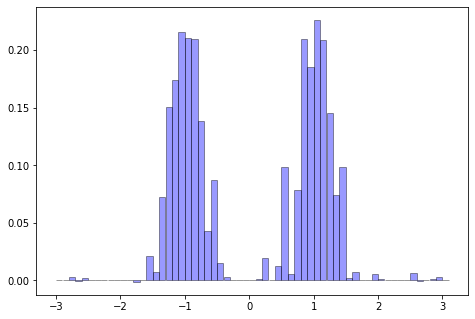

In [5]:
energy_spectrum(E_min = -3, E_max = 3, num_samples = 61, t = 0, sigma = 2, num_cycles = 10, num_shots = 1000, j = 1, nqubits = 2, sampler = sampler)

-1.5 :  0
-1.49 :  0.0
-1.48 :  0.0
-1.47 :  0
-1.46 :  0.0
-1.45 :  0.0
-1.44 :  0.0
-1.43 :  0
-1.42 :  0.0
-1.41 :  0
-1.4 :  0.0
-1.39 :  0
-1.38 :  0
-1.37 :  0.0
-1.36 :  0
-1.35 :  -0.0
-1.34 :  0
-1.33 :  0.0
-1.32 :  0.0
-1.31 :  0
-1.3 :  0
-1.29 :  0.0
-1.28 :  0
-1.27 :  0.0
-1.26 :  0.0
-1.25 :  0.0
-1.24 :  0.01
-1.23 :  -0.0
-1.22 :  0.0
-1.21 :  0.0
-1.2 :  0.01
-1.19 :  0.0
-1.18 :  0
-1.17 :  0.0
-1.16 :  0
-1.15 :  0.0
-1.14 :  -0.0
-1.13 :  -0.0
-1.12 :  0
-1.11 :  0
-1.1 :  0.01
-1.09 :  0.0
-1.08 :  -0.0
-1.07 :  -0.0
-1.06 :  0.0
-1.05 :  0.01
-1.04 :  0.12
-1.03 :  0.1
-1.02 :  0.09
-1.01 :  0.24
-1.0 :  0.23
-0.99 :  0.18
-0.98 :  0.15
-0.97 :  0.06
-0.96 :  0.02
-0.95 :  0.01
-0.94 :  0.01
-0.93 :  0.01
-0.92 :  0
-0.91 :  0.03
-0.9 :  0.0
-0.89 :  0
-0.88 :  0.0
-0.87 :  0
-0.86 :  0
-0.85 :  0.0
-0.84 :  0.0
-0.83 :  0
-0.82 :  0
-0.81 :  0
-0.8 :  0
-0.79 :  0
-0.78 :  0.0
-0.77 :  0.0
-0.76 :  0
-0.75 :  0
-0.74 :  0
-0.73 :  0
-0.72 :  0
-0.71 :  0
-0.7 :

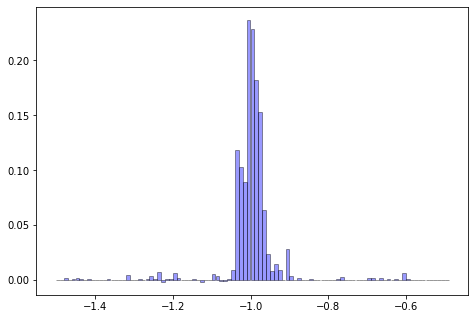

In [9]:
energy_spectrum(E_min = -1.5, E_max = -0.5, num_samples = 101, t = 0, sigma = 20, num_cycles = 10, num_shots = 1000, j = 1, nqubits = 2, sampler = sampler)

0.5 :  0.0
0.51 :  0
0.52 :  0.01
0.53 :  0
0.54 :  0
0.55 :  -0.0
0.56 :  0.0
0.57 :  0
0.58 :  0
0.59 :  0.0
0.6 :  0.0
0.61 :  0.01
0.62 :  0.0
0.63 :  0
0.64 :  0.0
0.65 :  0
0.66 :  0
0.67 :  0.01
0.68 :  0.01
0.69 :  0.0
0.7 :  0.0
0.71 :  0.0
0.72 :  0.0
0.73 :  0.0
0.74 :  0
0.75 :  0.0
0.76 :  0.0
0.77 :  0.0
0.78 :  -0.0
0.79 :  0
0.8 :  0.01
0.81 :  0
0.82 :  0
0.83 :  0
0.84 :  0.0
0.85 :  0
0.86 :  0
0.87 :  0
0.88 :  0.0
0.89 :  0
0.9 :  0
0.91 :  0.0
0.92 :  0.0
0.93 :  0
0.94 :  0.02
0.95 :  0.02
0.96 :  0.01
0.97 :  0.11
0.98 :  0.15
0.99 :  0.24
1.0 :  0.23
1.01 :  0.24
1.02 :  0.18
1.03 :  0.14
1.04 :  0.06
1.05 :  0.03
1.06 :  0.02
1.07 :  0.0
1.08 :  0.0
1.09 :  0.0
1.1 :  0
1.11 :  0.0
1.12 :  0
1.13 :  0.0
1.14 :  0.0
1.15 :  0
1.16 :  0
1.17 :  0
1.18 :  0
1.19 :  0
1.2 :  0
1.21 :  0
1.22 :  -0.0
1.23 :  0.0
1.24 :  0
1.25 :  0.0
1.26 :  0.0
1.27 :  0
1.28 :  0
1.29 :  0
1.3 :  0
1.31 :  0.0
1.32 :  0.0
1.33 :  0
1.34 :  0
1.35 :  0.05
1.36 :  0.0
1.37 :  0
1.3

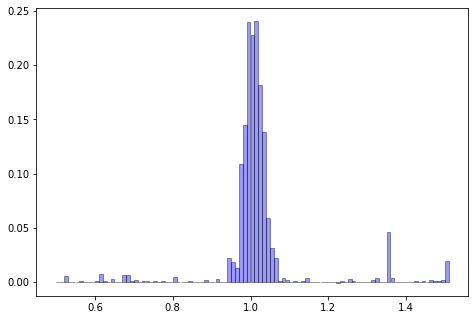

In [10]:
energy_spectrum(E_min = 0.5, E_max = 1.5, num_samples = 101, t = 0, sigma = 20, num_cycles = 10, num_shots = 1000, j = 1, nqubits = 2, sampler = sampler)

In [8]:
# energy_spectrum(E_min = 1.5, E_max = 2.5, num_samples = 101, t = 0, sigma = 20, num_cycles = 10, num_shots = 1000, j = 1, nqubits = 3, sampler = sampler)